### Load data

In [1]:
import os

os.listdir('./datasets/housing')

['housing.csv', 'housing.tgz', 'README.md']

There are 3 files but we need actually only housing.csv file

### Loading data using pandas

In [2]:
import pandas as pd

housing = pd.read_csv('./datasets/housing/housing.csv')

housing.head()
# housing.info()
# housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


There are 10 columns, 9 of them are numeric, the last one is categorical data

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- Column total_bedrooms has null values, we need to deal with this later
- All columns are in float format, last column is object, need to convert to categorical later

#### To discover the categorical data

In [4]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

There are 5 categories in total

#### Histogram of the data
calling the `hist()` method of a dataframe gives you the histogram

/Users/thaitrinh/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


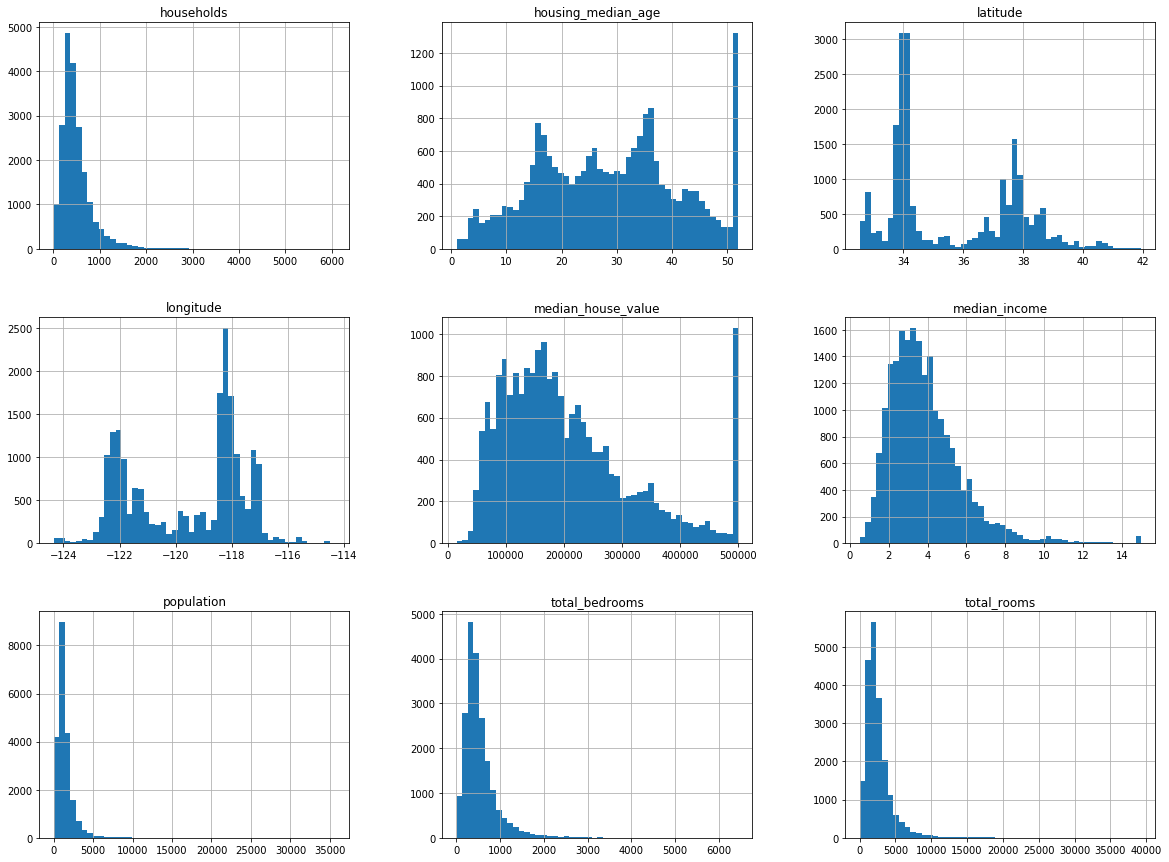

In [5]:
% matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 15))
hist = housing.hist(bins=50, ax=ax)

### Split data into train and test set

Suppose you chatted with experts who told you that the median income is a very
important attribute to predict median housing prices. You may want to ensure that
the test set is representative of the various categories of incomes in the whole dataset.
Since the median income is a continuous numerical attribute, you first need to create
an income category attribute. Let’s look at the median income histogram more closely. Most median income values are clustered around 2–5 (tens of thousands of dollars),
but some median incomes go far beyond 6.

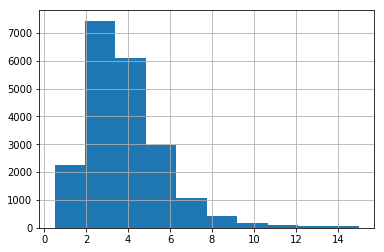

In [6]:
housing['median_income'].hist();

The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5 into category 5:

In [7]:
import numpy as np

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
#print(housing.income_cat)
# note this code. It's so nice that series also have where!!!
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
# housing.income_cat.hist(bins = np.arange(6)-0.5);
# plt.hist(housing.income_cat)

from sklearn.model_selection import StratifiedShuffleSplit

mysplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
print(type(mysplit))
print(mysplit)

<class 'sklearn.model_selection._split.StratifiedShuffleSplit'>
StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)


In [8]:
# since n_splits=1 we have only one list for train_index, one list for test_index
for train_index, test_index in mysplit.split(housing, housing['income_cat']):
    train_data = housing.loc[train_index]
    test_data = housing.loc[test_index]

Let’s see if this worked as expected. You can start by looking at the income category
proportions in the full housing dataset:

In [9]:
print(housing.income_cat.value_counts()/len(housing)) 
print(train_data.income_cat.value_counts()/len(train_data))
print(test_data.income_cat.value_counts()/len(test_data))

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64
3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


In [10]:
# remove income_cat to go back to the original data
train_data.drop(columns=['income_cat'], axis=1, inplace=True)
test_data.drop(columns=['income_cat'], axis=1, inplace=True)

### Discover and Visualize the Data

Let’s create a copy of the training set, so you can play with it without harming the training set:

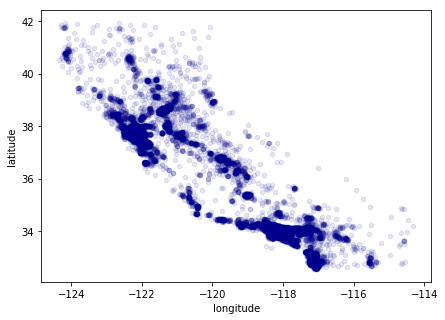

In [11]:
train_copy = train_data.copy()

# geography plot
train_copy.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1,figsize=(7,5), c='darkblue');
plt.show()

Note: using alpha=0.1 is quite helpful, we can see where the data are more dense

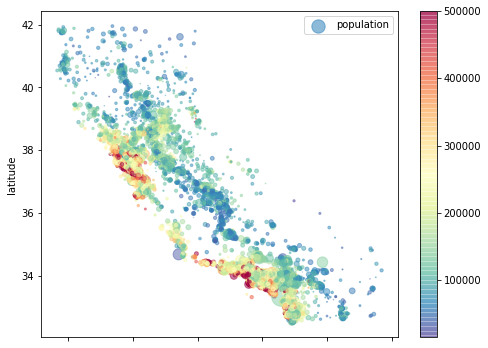

In [12]:
# add size to show population and color to show price
train_copy.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5,
                s=train_copy.population/100., c=train_copy.median_house_value,
                cmap=plt.cm.Spectral_r, colorbar=True, figsize=(8,6), label='population');
plt.legend();

This image tells you that the housing prices are very much related to the location
(e.g., close to the ocean) and to the population density, as you probably knew already.
It will probably be useful to use a clustering algorithm to detect the main clusters, and
add new features that measure the proximity to the cluster centers. The ocean proximity
attribute may be useful as well, although in Northern California the housing
prices in coastal districts are not too high, so it is not a simple rule.

### Looking for correlation

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64


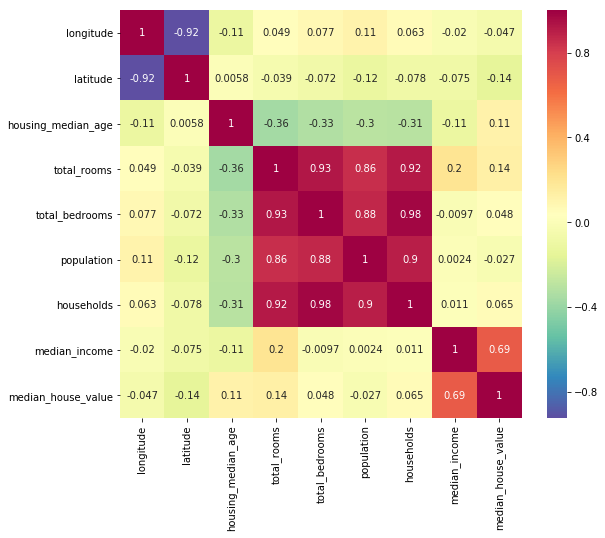

In [13]:
corr_matrix = train_copy.corr()

# which feature correlate strongest to the target?
print(corr_matrix['median_house_value'].sort_values(ascending=False))

import seaborn as sns
fig, ax = plt.subplots(figsize=(9,7.5))   
sns.heatmap(corr_matrix, annot=True, ax=ax, cmap=plt.cm.Spectral_r);

- So we can see that the attributes which have strongest correlation with the median_house_value are median_income, total_rooms, housing_median_age.
- The correlation coefficient only measures linear correlations (“if x goes up, then y generally goes up/down”). It may completely miss out on nonlinear relationships (e.g., “if x is close to zero then y generally goes up”).
- We can also use pandas plot tools called scatter_matrix to plot and see the correlation. Since there are now 11 numerical attributes, you would get 121 plots, which would not fit on a page, so let’s just focus on a few promising attributes that seem most correlated with the median housing value

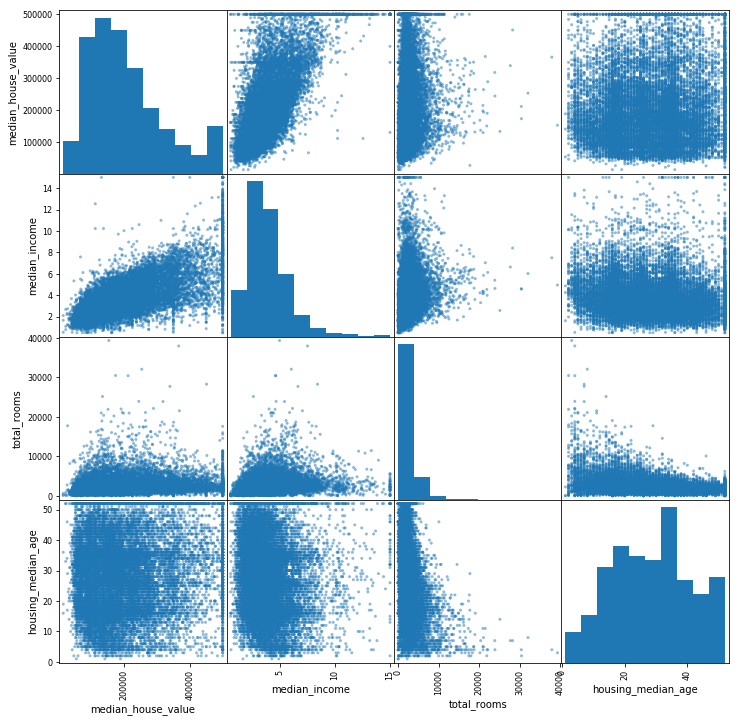

In [14]:
from pandas.plotting import scatter_matrix

att = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(train_copy[att], figsize=(12, 12));

Let's zoom in into the best correlation. We will see the horizontal lines at 50k, 450k, 350k and probably also at 280k. We may want to remove these data before feeding it into maching learning algorithm

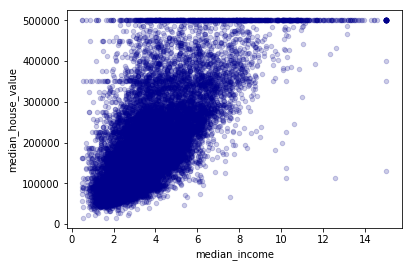

In [15]:
train_copy.plot(kind='scatter', x='median_income', y='median_house_value', c="darkblue", alpha=0.2);

### Attribute combination

- The total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household.

- Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms.

- And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes:

In [16]:
train_copy['rooms_per_household'] = train_copy['total_rooms']/train_copy['households']
train_copy["bedrooms_per_room"] = train_copy["total_bedrooms"]/train_copy["total_rooms"]
train_copy["population_per_household"]=train_copy["population"]/train_copy["households"]

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64


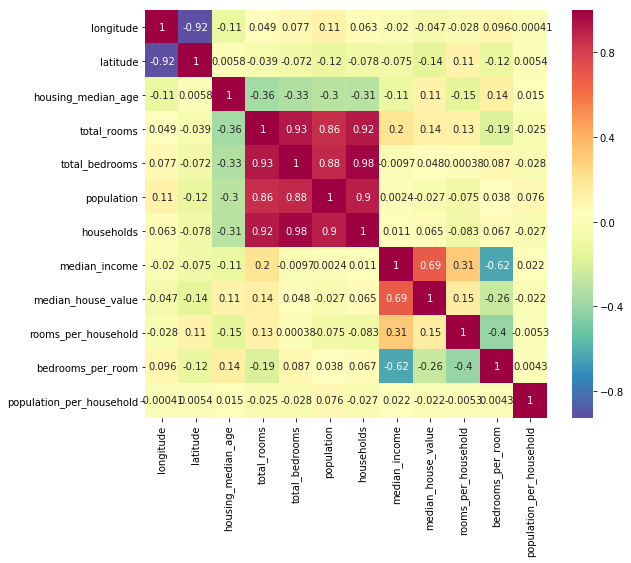

In [17]:
# now look at the correlation matrix again
corr_matrix2 = train_copy.corr()
print(corr_matrix2['median_house_value'].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(9, 7.5))
sns.heatmap(corr_matrix2, annot=True, ax=ax, cmap=plt.cm.Spectral_r);

### Preparing data for machine learning algorithm

In [18]:
xtrain = train_data.drop('median_house_value', axis=1)
ytrain = train_data['median_house_value']

xtest = test_data.drop('median_house_value', axis=1)
ytest = test_data['median_house_value']

print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(16512, 9) (16512,)
(4128, 9) (4128,)


#### Cleaning data (manually)

You noticed earlier that the total_bedrooms attribute has some missing values, so let’s fix this. You have three options:
- Get rid of the corresponding districts.
- Get rid of the whole attribute.
- Set the values to some value (zero, the mean, the median, etc.)

If you choose option 3, you should compute the median value on the training set, and use it to fill the missing values in the training set, but also don’t forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

In [19]:
# xtrain.dropna(subset=["total_bedrooms"]) # option 1
# xtrain.drop("total_bedrooms", axis=1) # option 2
# median = xtrain["total_bedrooms"].median()
# xtrain["total_bedrooms"].fillna(median) # option 3

#### Cleaning using sklearn Imputer

- The imputer has simply computed the median of each attribute and stored the result in its `statistics_` instance variable.
- Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes:

In [20]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
xtrain_num = xtrain.drop(columns=["ocean_proximity"])
imputer.fit(xtrain_num)
# check if imputer calculate the correct median :) 
# print(imputer.statistics_)
# print(xtrain_num.median().values)

# then use imputer to transform data
x_num = imputer.transform(xtrain_num)
# and put it back to data frame format
xtrain_num_trans = pd.DataFrame(x_num, columns=xtrain_num.columns)
xtrain_num_trans.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


#### Handing categorical data

In [21]:
housing_cat = xtrain["ocean_proximity"]

In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
house_cat_encoded = label_encoder.fit_transform(housing_cat)
house_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [23]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
house_cat_onehot = onehot_encoder.fit_transform(house_cat_encoded.reshape(-1, 1))
house_cat_onehot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

We can apply both transformations (from text categories to integer categories, then from integer categories to one-hot vectors) in one shot using the LabelBinarizer class:

In [24]:
from sklearn.preprocessing import LabelBinarizer

lb_encoder = LabelBinarizer(sparse_output=True)
cat_onehot = lb_encoder.fit_transform(housing_cat)
cat_onehot

<16512x5 sparse matrix of type '<class 'numpy.int64'>'
	with 16512 stored elements in Compressed Sparse Row format>

__Note__: Sometimes we need to write a customer transformer. all you need is to create a class and implement three methods: fit() (returning self), transform(), and fit_transform(). You can get the last one for free by simply adding TransformerMixin as a base class. Also, if you add BaseEstimator as a base class (and avoid *args and **kargs in your constructor) you will get two extra methods (get_params() and set_params()) that will be useful for automatic
hyperparameter tuning. Example of a small transformer class that adds the combined attributes we discussed earlier can be seen in the book

#### Adding features

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

# column numbers of some attributes
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        # 2 features are always added
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        # one feature can be added or not based on the boolean parameter
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            # np.c_ Translates slice objects to concatenation along the second axis.
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            #print(X.shape)
            #print(rooms_per_household.shape)
            #print(np.c_[X, rooms_per_household, population_per_household].shape)
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(xtrain.values)

#### Feature scaling

- MinMaxScaler: substract min and divide by (max-min) -> range(0,1)
- StandardScaler: substract mean and divide by variance -> 0 mean and 1 variance
- StandardScaler is much less affected by outliers

#### Transformation Pipelines

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# create a transformation pipeline for numeric data
num_pipeline = Pipeline([("imputer", Imputer(strategy="median")),
                        ("add_attributes", CombinedAttributesAdder()),
                        ("std_scaler", StandardScaler())])

housing_num_transformed = num_pipeline.fit_transform(xtrain_num)

#### Join numeric transformation and categorical transformation

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion


class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse_output=False):
        self.sparse_output = sparse_output
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        enc = LabelBinarizer(sparse_output=self.sparse_output)
        return enc.fit_transform(X)

# first write a Selector to just select the data
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_att = list(xtrain_num)
cat_att = ["ocean_proximity"]

num_pipeline = Pipeline([("selector", DataFrameSelector(num_att)), 
                         ("imputer", Imputer(strategy="median")),
                        ("add_attributes", CombinedAttributesAdder()),
                        ("std_scaler", StandardScaler())])

cat_pipeline = Pipeline([("selector", DataFrameSelector(cat_att)),
                     ("onehot", CustomLabelBinarizer())])

full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline),
                                              ("cat_pipeline", cat_pipeline)])

In [28]:
housing_prepared = full_pipeline.fit_transform(xtrain)

In [29]:
housing_prepared.shape

(16512, 16)

### Select and Train Model

In [30]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
# try to predict some data rows
some_data = xtrain.iloc[:5]
some_labels = ytrain.iloc[:5]
# This will not work because from 5 rows we don't have all categories
# so the output data don't have 16 columns but just 14
# some_data_prepared = full_pipeline.transform(some_data)
# print(some_data_prepared.shape)
# print("Predictions:\t", lin_reg.predict(some_data_prepared))
# print("Labels:\t\t", list(some_labels))

In [39]:
from sklearn.metrics import mean_squared_error, r2_score

print("rmse train:", np.sqrt(mean_squared_error(ytrain, lin_reg.predict(housing_prepared))))
print("r2 train:", r2_score(ytrain, lin_reg.predict(housing_prepared)))

xtest_prepared = full_pipeline.transform(xtest)
print("rmse test:", np.sqrt(mean_squared_error(ytest, lin_reg.predict(xtest_prepared))))
print("r2 test:", r2_score(ytest, lin_reg.predict(xtest_prepared)))

rmse train: 68628.19819848923
r2 train: 0.6481624842804428
rmse test: 66911.98070857547
r2 test: 0.6564352347280719


Okay, this is better than nothing but clearly not a great score: most districts’ median_housing_values range between $120,000 and $265,000, so a typical prediction error of $68,628 is not very satisfying.